In [1]:
import abc

In [2]:
import numpy as np

In [3]:
np.seterr(all='raise', under='warn')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [4]:
np.set_printoptions(precision=20)

---

activation function

In [5]:
class ActivationFunction(abc.ABC):
    """Base class for activation functions."""
    
    def __init__(self):
        """Init function. Nothing needs to do in the base class."""
        pass
    
    @property
    @abc.abstractmethod
    def derivative_use_activated(self):
        """Boolean: If derivative of the activation function can be calculated
        using activated value.
        """
        pass
    
    @abc.abstractmethod
    def apply(self, v):
        """Apply activation function on the data.
        
        Args:
            v (np.array): Data
        
        Returns:
            Activated values
        """
        pass
    
    @abc.abstractmethod
    def derivative(self, v):
        """Calculate derivative wrt input of activation function.
        
        Args:
            v (np.array): input of activation function if derivative_use_activated is false,
                output of activation function otherwise
        
        Returns:
            Derivative wrt input of activation function
        """
        pass

In [6]:
class ActivationNone(ActivationFunction):
    """For not using an activation function"""
    
    def __init__(self):
        """Init function. Do nothing."""
        pass
    
    @property
    def derivative_use_activated(self):
        """Arbitrary. Not used."""
        return True
    
    def apply(self, v):
        """Return input as output as no activation needs to be applied.
        
        Args:
            v (np.array): Data
        
        Returns:
            The same as input v
        """
        return v
    
    def derivative(self, v):
        """Calculate derivative wrt input of activation function.
        
        Args:
            v (np.array): input of activation function if derivative_use_activated is false,
                output of activation function otherwise
        
        Returns:
            Always 1
        """
        return 1

In [7]:
class ActivationSigmoid(ActivationFunction):
    """Sigmoid function. Data out of bounds will be clipped."""
    
    def __init__(self, x_upper_bound=None, x_lower_bound=None):
        """Init function.
        
        Args:
            x_upper_bound (int): Upper bound of sigmoid input
            x_lower_bound (int): Lower bound of sigmoid input
        """
        self.x_upper_bound = x_upper_bound
        self.x_lower_bound = x_lower_bound
    
    @property
    def derivative_use_activated(self):
        """Use sigmoid result to calculate derivative."""
        return True
    
    def apply(self, v):
        """Apply sigmoid function to data.
        
        Args:
            v (np.array): Data
        
        Returns:
            1 / (1 + exp(v)). v will be clipped if bounds are set.
        """
        if self.x_upper_bound or self.x_upper_bound:
            return 1.0 / (1.0 + np.exp(-v.clip(max=self.x_upper_bound, min=self.x_lower_bound)))
        return 1.0 / (1.0 + np.exp(-v))
    
    def derivative(self, v):
        """Calculate derivative wrt input of activation function.
        
        Args:
            v (np.array): input of activation function if derivative_use_activated is false,
                output of activation function otherwise
        
        Returns:
            v * (1 - v)
        """
        return v * (1 - v)

In [8]:
class ActivationRelu(ActivationFunction):
    """Relu function."""
    def __init__(self):
        """Init function. Do nothing."""
        pass
    
    @property
    def derivative_use_activated(self):
        """Use result to calculate derivative."""
        return True
    
    def apply(self, v):
        """Apply Relu to data.
        
        Args:
            v (np.array): Data
        
        Returns:
            v if v > 0, otherwise 0
        """
        return v.clip(min=0)
    
    def derivative(self, v):
        """Calculate derivative wrt input of activation function.
        
        Args:
            v (np.array): input of activation function if derivative_use_activated is false,
                output of activation function otherwise
        
        Returns:
            1 if v > 0, otherwise 0
        """
        return np.where(v>0, 1, 0)

---

gd updater

In [9]:
class GDUpdater(abc.ABC):
    """Base class for gradient descent updater. One updater to N layers."""
    
    def __init__(self):
        """Init function.
        
        Attributes:
            weight_infos (dict): buff to store any step result for weight
            bias_infos (dict): buff to store any step result for bias terms
        """
        self.weight_infos = {}
        self.bias_infos = {}
    
    def register_layer(self, layer_id, weight_shape, bias_shape):
        """Register layer which will use this updater.
        
        Args:
            layer_id (int/str): key to specify the layer
            weight_shape (int): shape of weight of the layer
            bias_shape (int): shape of bias terms of the layer
        """
        self.weight_infos[layer_id] = np.zeros(weight_shape)
        self.bias_infos[layer_id] = np.zeros(bias_shape)
    
    @abc.abstractmethod
    def apply(self, layer_id, grads, bias_grads):
        """Calculate update value.
        
        Args:
            layer_id (int/str): key to specify the layer
            grads (np.array): gradients of weights
            bias_grads (np.array): gradients of bias terms
        
        Returns:
            Calculated gradients/update value
        """
        pass

In [10]:
class GDUpdaterNormal(GDUpdater):
    """No optimization, apply learning rate only."""
    
    def __init__(self, learning_rate):
        """Init function.
        
        Attributes:
            learning_rate (float): learning rate
        """
        GDUpdater.__init__(self)
        self.learning_rate = learning_rate
    
    def apply(self, layer_id, grads, bias_grads):
        """Calculate update value.
        
        Args:
            layer_id (int/str): key to specify the layer
            grads (np.array): gradients of weights
            bias_grads (np.array): gradients of bias terms
        
        Returns:
            learning_rate * gradients
        """
        return self.learning_rate * grads, self.learning_rate * bias_grads

In [11]:
# Need a smaller learning rate(0.01?)
class GDUpdaterMomentum(GDUpdater):
    """Momentum for SGD.
    
    In Momentum, weight_infos and bias_infos stores the last calculated weight deltas.
    """
    
    def __init__(self, learning_rate, gamma=0.9):
        """Init function.
        
        Attributes:
            learning_rate (float): learning rate
            gamma (float): rate of the update vector of the past time step to add on, default 0.9
        """
        GDUpdater.__init__(self)
        self.learning_rate = learning_rate
        self.gamma = gamma
    
    def apply(self, layer_id, grads, bias_grads):
        """Calculate update value.
        
        Args:
            layer_id (int/str): key to specify the layer
            grads (np.array): gradients of weights
            bias_grads (np.array): gradients of bias terms
        
        Returns:
            gamma * last_gradients + learning_rate * current_gradients
        """
        self.weight_infos[layer_id] = self.gamma*self.weight_infos[layer_id] + self.learning_rate*grads
        self.bias_infos[layer_id] = self.gamma*self.bias_infos[layer_id] + self.learning_rate*bias_grads
        return self.weight_infos[layer_id], self.bias_infos[layer_id]

In [12]:
class GDUpdaterAdagrad(GDUpdater):
    def __init__(self, learning_rate=0.01, epsilon=1e-8):
        GDUpdater.__init__(self)
        self.learning_rate = learning_rate
        self.epsilon = epsilon
    
    def apply(self, layer_id, grads, bias_grads):
        # TODO
        pass

In [13]:
class GDUpdaterAdadelta(GDUpdater):
    def __init__(self, gamma=0.9, epsilon=1e-8):
        GDUpdater.__init__(self)
        self.gamma = gamma
        self.epsilon = epsilon
    
    def apply(self, layer_id, grads, bias_grads):
        # TODO
        pass

In [14]:
class GDUpdaterRMSprop(GDUpdater):
    """RMSprop.
    
    In RMSprop, weight_infos and bias_infos stores the last calculated E[g^2].
    """
    
    def __init__(self, learning_rate=0.001, gamma=0.9, epsilon=1e-8):
        """Init function.
        
        Attributes:
            learning_rate (float): learning rate, default 0.001
            gamma (float): rate of the update E[g^2] of the past time step to add on, default 0.9
            epsilon (float):  smoothing term that avoids division by zero, default 1e-8
        """
        GDUpdater.__init__(self)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        
    def apply(self, layer_id, grads, bias_grads):
        """Calculate update value.
        
        Args:
            layer_id (int/str): key to specify the layer
            grads (np.array): gradients of weights
            bias_grads (np.array): gradients of bias terms
        
        Returns:
            E[g^2] = gamma * last_E[g^2] + (1-gamma) * current_gradients^2
            learning_rate * gradients / sqrt(E[g^2] + epsilon)
        """
        self.weight_infos[layer_id] = self.gamma*self.weight_infos[layer_id] \
            + (1-self.gamma)*np.power(grads,2)
        self.bias_infos[layer_id] = self.gamma*self.bias_infos[layer_id] \
            + (1-self.gamma)*np.power(bias_grads,2)
        weight_delta = self.learning_rate * grads / np.sqrt(self.weight_infos[layer_id] + self.epsilon)
        bias_delta = self.learning_rate * bias_grads / np.sqrt(self.bias_infos[layer_id] + self.epsilon)
        return weight_delta, bias_delta

---

nn layer

In [15]:
class NNLayer(abc.ABC):
    """Base class for neural network layers."""
    
    def __init__(self):
        """Init function. Nothing needs to do in the base class."""
        pass
    
    def init(self):
        """Init function during model creation. Nothing needs to do in the base class."""
        pass
    
    @abc.abstractmethod
    def forward(self, step_input, learning=True):
        """Run through the layer with given input to get output.
        
        Args:
            step_input (np.array): input data
            learning (boolean): flag if current step is in learning period
                During learning period, intermediate result is stored for back propagation.
        
        Returns:
            Result calculated by current layer
            activation(input*weights+bias)
        """
        pass
    
    @abc.abstractmethod
    def back_propagation(self, prev_delta, activation_derivatived=False):
        """Back propagation to calculate gradient in last step for update.
        Store the gradients in weight_grads and bias_grads.
        
        Args:
            prev_delta (np.array): delta values(derivatives) from the next layer
                wrt output of current layer
            activation_derivatived (boolean): if the delta value contains
                derivative of activation function
        
        Returns:
            Derivatives of current layer wrt input
        """
        pass
    
    @abc.abstractmethod
    def update(self):
        """Update weights of each input nodes using calculated gradients for last step.
        Use pre-specified GD updater for accelerating convergance during GD update.
        """
        pass
    
    def xavier_weight_init(self, prev_node_count, cur_node_count, has_bias):
        """Initialize weight using Xavier init.
        
        Args:
            prev_node_count (int): number of input data (output of previous layer)
            cur_node_count (int): number of nodes (output of current layer)
            has_bias (boolean): flags if bias terms are added
        
        Returns:
            Initialized weights and bias terms
        """
        weights = np.random.randn(prev_node_count, cur_node_count)/np.sqrt(prev_node_count)
        bias = np.random.randn(cur_node_count)/np.sqrt(prev_node_count) \
            if has_bias else np.zeros(cur_node_count)
        return weights, bias

In [16]:
class FCLayer(NNLayer):
    """Single layer of neural network"""
    
    def __init__(self, node_count, has_bias=True, activation=ActivationNone()):
        """Init function.
        
        Attributes:
            layer_id (int/str): ID of current layer
            node_count (int): number of nodes of current layer
            has_bias (boolean): flag if the nodes of the layer has bias terms
            activation (ActivationFunction): activation function
            gd_updater (GDUpdater): gradient descent updater
            weights (np.array): input weights of all nodes
            bias (np.array): bias of all nodes
            weight_grads (np.array): weight gradients of all nodes of current step 
            bias_grads (np.array): bias gradients of all nodes of current step 
            step_input (np.array): input of current step
            reduced_sum (np.array): reduced sum of input before activation of current step 
            step_output (np.array): output of current step
        """
        self.layer_id = None
        self.node_count = node_count
        self.has_bias = has_bias
        self.activation = activation
        self.gd_updater = None
        self.weights = None
        self.bias = None
        self.weight_grads = None
        self.bias_grads = None
        self.step_input = None
        self.reduced_sum = None
        self.step_output = None
    
    def init(self, prev_node_count, gd_updater):
        """Init function during model creation. Initialize layer info and nodes.
        
        Args:
            prev_node_count (int): number of input of current layer
            gd_updater (GDUpdater): gradient descent updater
        """
        self.layer_id = id(self)
        self.gd_updater = gd_updater
        self.weights, self.bias = self.xavier_weight_init(prev_node_count, self.node_count, self.has_bias)
        self.gd_updater.register_layer(self.layer_id, self.weights.shape, self.bias.shape)
    
    def forward(self, step_input, learning=True):
        """Run through the layer with given input to get output.
        
        Args:
            step_input (np.array): input data
            learning (boolean): flag if current step is in learning period
                During learning period, intermediate result is stored for back propagation.
        
        Returns:
            Result calculated by current layer
            activation(input*weights+bias)
        """
        reduced_sum = np.dot(step_input, self.weights) + self.bias
        step_output = self.activation.apply(reduced_sum)
        if learning:
            self.step_input = step_input
            self.reduced_sum = reduced_sum
            self.step_output = step_output
        return step_output
    
    def back_propagation(self, prev_delta, activation_derivatived=False):
        """Back propagation to calculate gradient in last step for update.
        Store the gradients in weight_grads and bias_grads.
        
        Args:
            prev_delta (np.array): delta values(derivatives) from the next layer
                wrt output of current layer
            activation_derivatived (boolean): if the delta value contains
                derivative of activation function
        
        Returns:
            Derivatives of current layer wrt input
        """
        cur_delta = None
        if activation_derivatived:
            cur_delta = prev_delta
        elif self.activation.derivative_use_activated:
            cur_delta = prev_delta * self.activation.derivative(self.step_output)
        else:
            cur_delta = prev_delta * self.activation.derivative(self.reduced_sum)
        self.weight_grads = np.dot(np.atleast_2d(self.step_input).T, cur_delta)/cur_delta.shape[0]
        self.bias_grads = cur_delta.mean(axis=0)
        return np.dot(cur_delta, self.weights.T)
    
    def update(self):
        """Update weights of each input nodes using calculated gradients for last step.
        Use pre-specified GD updater for accelerating convergance during GD update.
        """
        weight_deltas, bias_deltas = \
            self.gd_updater.apply(self.layer_id, self.weight_grads, self.bias_grads)
        self.weights -= weight_deltas
        if self.has_bias:
            self.bias -= bias_deltas

---

nn model

In [17]:
class NNModel:
    def __init__(self, X_size, gd_updater):
        """Init function.
        
        Attributes:
            X_size (int): number of input data
            gd_updater (GDUpdater): gradient descent updater for GD update
            model (list(NNLayer)): layers of current model
        """
        self.X_size = X_size
        self.gd_updater = gd_updater
        self.model = []
    
    def add_layer(self, layer):
        """Add one layer to the model.
        
        Args:
            layer (NNLayer): Layer to be added
        """
        input_size = self.X_size
        if self.model:
            input_size = self.model[-1].node_count
        layer.init(input_size, self.gd_updater)
        self.model.append(layer)
    
    def model_forward(self, X, learning=True):
        """Forward pass, Run through each layers with given input X to get predict value.
        Support both batch and single sample.
        Intermediate result is stored for back propagation if learning is set to True.
        
        Args:
            X (np.array): input data
            learning (boolean): flag if current step is in learning period
                During learning period, intermediate result is stored for back propagation.
        
        Returns:
            Result calculated by current model(all layers)
        """
        cur_res = X
        for layer in self.model:
            cur_res = layer.forward(cur_res, learning=learning)
        return cur_res
    
    def predict(self, X):
        """Forward pass, run through each layers with given input X to get predict value.
        Support both batch and single sample.
        Intermediate result is not stored.
        
        Args:
            X (np.array): input data
        
        Returns:
            Result calculated by current model
        """
        return self.model_forward(X, learning=False)
    
    def update_model(self, y_predict, y):
        """Update parameters of each layer using errs (y_predict - y) in current step.
        
        Args:
            y_predict (np.array): predict values
            y (np.array): target data
        """
        delta = np.atleast_2d(y_predict - y)
        for layer in reversed(self.model):
            delta = layer.back_propagation(delta, activation_derivatived=(layer==self.model[-1]))
        for layer in self.model:
            layer.update()

---

test

In [85]:
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn import metrics

In [86]:
test_data = sklearn.datasets.load_boston(return_X_y=False)

In [87]:
test_data_x_org = test_data['data']
test_data_y_org = test_data['target']

In [88]:
test_data_x_org.shape

(506, 13)

In [89]:
test_data_std = (test_data_x_org - np.mean(test_data_x_org, axis=0)) / np.std(test_data_x_org, axis=0)

In [90]:
test_data_x = test_data_std[:450]
test_data_y = test_data_y_org[:450]

In [233]:
learning_rate = 0.01

In [234]:
rounds = 2000

In [235]:
batch_size = 50

In [246]:
m = NNModel(test_data_x.shape[1], GDUpdaterRMSprop())

In [247]:
# m.add_layer(FCLayer(20, False, ActivationNone()))
m.add_layer(FCLayer(node_count=10, activation=ActivationNone()))
m.add_layer(FCLayer(node_count=1, activation=ActivationNone()))

In [248]:
%%time
all_cost = []
all_cost_ce = []
for _ in range(rounds):
    cost = 0
    cost_ce = 0
    learning_idx = np.arange(len(test_data_x))
    np.random.shuffle(learning_idx)
    
    for start_idx in range(0, len(test_data_x), batch_size):
        data_idx = learning_idx[start_idx : min(start_idx+batch_size,len(test_data_x))]
#         data_idx = learning_idx[start_idx]
        sample, target = test_data_x[data_idx], test_data_y[data_idx,None]
        predict = m.model_forward(sample)
        err = predict - target
        m.update_model(predict, target)
        cost += (err*err).sum()
#         cost_ce -= (target*np.log(predict)+(1-target)*np.log(1-predict)).sum()
    all_cost.append(cost)
    all_cost_ce.append(cost_ce)

Wall time: 3.62 s


In [249]:
all_cost[-1]

10555.44476988625

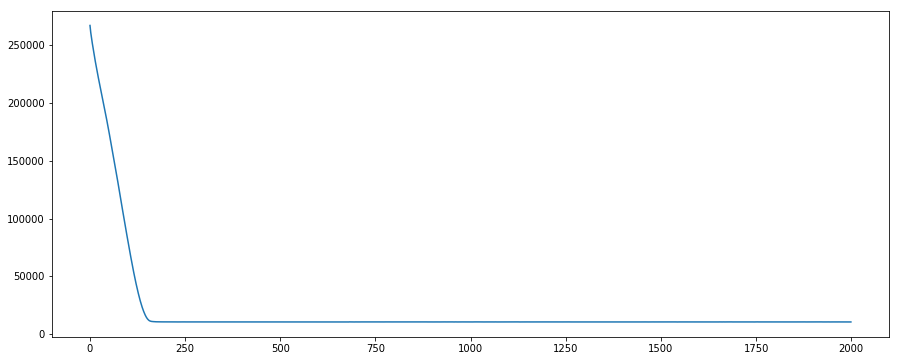

In [250]:
plt.figure(figsize=(15,6))
plt.plot(all_cost)

In [251]:
predict_data_x = test_data_std[450:]
predict_data_y = test_data_y_org[450:]

In [252]:
predict_y = []
for sample, tgt in zip(predict_data_x, predict_data_y):
    pct = m.model_forward(sample)
    predict_y.append(pct)

In [253]:
metrics.mean_squared_error(predict_data_y, predict_y)

11.360365785711753

test_ob

In [244]:
predict_data_y

array([13.4, 15.2, 16.1, 17.8, 14.9, 14.1, 12.7, 13.5, 14.9, 20. , 16.4,
       17.7, 19.5, 20.2, 21.4, 19.9, 19. , 19.1, 19.1, 20.1, 19.9, 19.6,
       23.2, 29.8, 13.8, 13.3, 16.7, 12. , 14.6, 21.4, 23. , 23.7, 25. ,
       21.8, 20.6, 21.2, 19.1, 20.6, 15.2,  7. ,  8.1, 13.6, 20.1, 21.8,
       24.5, 23.1, 19.7, 18.3, 21.2, 17.5, 16.8, 22.4, 20.6, 23.9, 22. ,
       11.9])

In [245]:
predict_y

[array([16.67015233315926]),
 array([19.980848042032374]),
 array([19.04222217531037]),
 array([23.36728988604503]),
 array([15.363414347558184]),
 array([15.893719207164278]),
 array([12.506628768998212]),
 array([12.700568622780867]),
 array([17.508780664417216]),
 array([18.990661286728354]),
 array([19.537137943199436]),
 array([20.79259552935968]),
 array([20.357518627844968]),
 array([23.322061447320014]),
 array([20.821352165407163]),
 array([18.032916353142653]),
 array([14.340300863001808]),
 array([17.19222542783421]),
 array([17.155359141266803]),
 array([18.793513785587685]),
 array([20.743208708273162]),
 array([23.840138991324277]),
 array([23.14233701414988]),
 array([26.441944810505447]),
 array([16.59642958586252]),
 array([16.224713151116454]),
 array([21.095798063971685]),
 array([11.280095125973304]),
 array([19.65100726033516]),
 array([22.45744965150684]),
 array([24.246926890215523]),
 array([28.26489302941579]),
 array([29.899032458926758]),
 array([21.589290891